In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re
from scipy.stats import pearsonr
from subprocess import check_output

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import cm
import matplotlib as mpl
sns.set(font_scale=1.5, style="whitegrid")

import dask.bag as db
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [2]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import precalculated decodings

In [4]:
precalc_file = "synthetic_tags/10_11_19_run_02_misl_100k_scaled.tsv"

In [5]:
subsample_df = pd.read_csv(precalc_file, sep="\t", index_col=None, comment="#")

In [6]:
subsample_df

,sample_depth,sample_i,correct_decoding,codeword_at_t,closest_msg,closest_d,t
0,29,0,False,0000000001001000000100000000000010000000100100...,00110000010011001001111000000000,19,0.0
1,29,0,False,0000000001001000000100000000000010000000100000...,00000100001010000011000000000000,19,1.0
2,29,0,False,0000000000000000000000000000000010000000100000...,00000000110000000000001000010000,19,2.0
3,29,0,False,0000000000000000000000000000000000000000100000...,00001000001001000000000100000000,19,3.0
4,29,1,False,0000010001000000010101100000000010010110000101...,00000000010000010101001000011010,19,0.0
...,...,...,...,...,...,...,...
13563,100000,9,False,0000000000000000000000000000000000000010000000...,11100000000001000000001000100001,18,3166.0
13564,100000,9,False,0000000000000000000000000000000000000000000000...,10000000001000001001000000000000,19,3624.0
13565,100000,9,False,0000000000000000000000000000000000000000000000...,00100000000100000000000000000000,19,3694.0
13566,100000,9,False,0000000000000000000000000000000000000000000000...,00010010000100000100000010000000,18,3730.0


In [7]:
# How many of the samples/depths/thresholds have at least one decoding w/ distance d=12 or lower?
depth_i = 0
closest_depth_df = []
for depth, depth_df in subsample_df.groupby("sample_depth"):

    for sample_i, sample_df in depth_df.groupby("sample_i"):
        sample_df.index = range(len(sample_df))
        ts = sample_df["t"]
        ds = sample_df["closest_d"]
        min_d_ix = np.argmin(ds)
        min_d = ds[min_d_ix]
        correct = sample_df.loc[min_d_ix, "correct_decoding"]
        if min_d <= 14:
            closest_depth_df.append((depth, sample_i, True, min_d, correct))
        else:
            closest_depth_df.append((depth, sample_i, False, min_d, correct))
closest_depth_df = pd.DataFrame(closest_depth_df, columns=["sample_depth", "sample_i", "has_distance <=14", "closest_d", "correct_decoding"])

In [8]:
errs_over_time_data = {}
sampled_runtime = []
mean_dist = []
std_dist = []
for depth, df in closest_depth_df.groupby("sample_depth"):
    sampled_runtime.append(depth / 4000. * 60)
    mean_dist.append(np.mean(df["closest_d"]))
    std_dist.append(np.std(df["closest_d"]))

errs_over_time_data["sampled_runtime"] = sampled_runtime
errs_over_time_data["mean_dist"] = mean_dist
errs_over_time_data["std_dist"] = std_dist

df = df[df["correct_decoding"] == False]
depths = df["sample_depth"]/ 4000. * 60
dists = df["closest_d"] 

errs_over_time_data["incorrect_pts"] = list(zip(depths, dists))

In [9]:
from matplotlib.cm import get_cmap

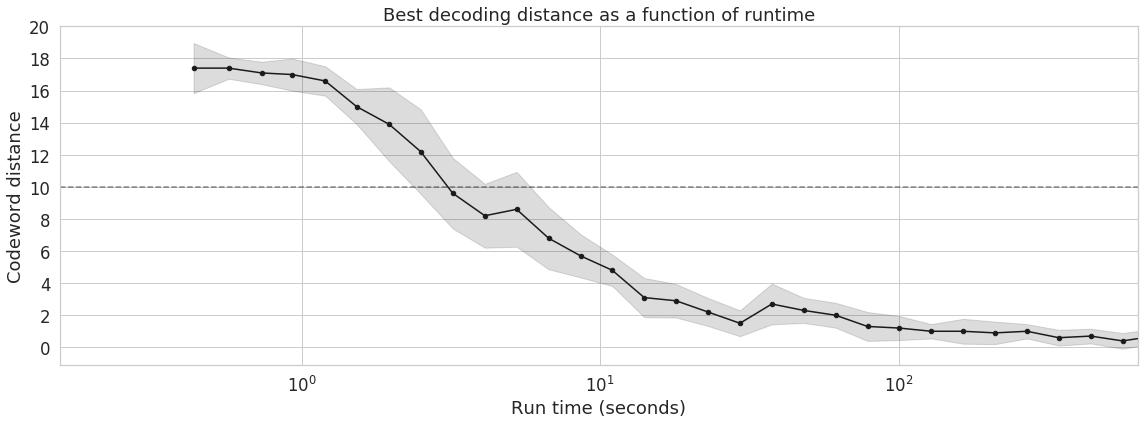

In [10]:
fig, ax = plt.subplots(figsize=(16, 6))

data = errs_over_time_data
color = "k"
ax.plot(data["sampled_runtime"], data["mean_dist"], linestyle='-', marker='.', c=color, ms=9)
ax.fill_between(data["sampled_runtime"],
            [y - s for y, s in zip(data["mean_dist"], data["std_dist"])],
            [y + s for y, s in zip(data["mean_dist"], data["std_dist"])],
            color=color, alpha=0.15)

ax.set_xlabel("Run time (seconds)")
ax.set_ylabel("Codeword distance")
ax.set_title("Best decoding distance as a function of runtime")
ax.set_xscale("log")
ax.set_yticks(range(0, 21, 2))
ax.set_yticklabels([str(x) for x in range(0, 21, 2)])

ax.set_xlim([0.155, 630])
ax.axhline(10, c="k", alpha=0.5, linestyle="--")

fig.tight_layout()


In [11]:
depth_i = 0
max_d = 10
first_d_below_maxd = []
for depth, depth_df in subsample_df.groupby("sample_depth"):
    for sample_i, sample_df in depth_df.groupby("sample_i"):
        ts = sample_df["t"]
        ds = sample_df["closest_d"]

        found = False
        for i, d in ds.iteritems():
            if d <= max_d:
                found = True
                correct = sample_df.loc[i, "correct_decoding"]
                first_d_below_maxd.append((depth, sample_i, True, d, ts[i], correct))
                break
        if not found:
            first_d_below_maxd.append((depth, sample_i, False, None, None, None))
first_d_below_maxd = pd.DataFrame(first_d_below_maxd, columns=["sample_depth", "sample_i", "has_distance <=14", "d", "t", "correct_decoding"])

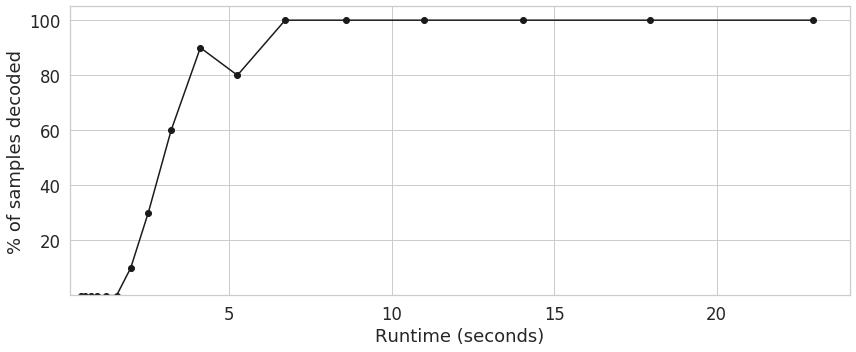

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))
firstd_df = first_d_below_maxd
color = "k"
no_na = firstd_df.dropna(inplace=False)
no_decoding = firstd_df.drop(no_na.index, inplace=False)
frac = []
runtime = []
for sample_depth in np.unique(firstd_df["sample_depth"]):
    if sample_depth > 1800:
        break
    nd = len(no_decoding[no_decoding["sample_depth"] == sample_depth])
    frac.append(100. * (10 - nd) / 10)
    runtime.append(sample_depth / 4000 * 60)
ax.plot(runtime, frac, marker="o", c=color)
    
ax.set_xlabel("Runtime (seconds)")
ax.set_ylabel("% of samples decoded")
ax.set_ylim([0.1, ax.get_ylim()[1]])
ax.set_xlim([0.1, ax.get_xlim()[1]])
# ax.legend()
fig.tight_layout()


# fig.savefig("plots/decoding_ability_over_time_leftend.png", dpi=300)
# fig.savefig("plots/decoding_ability_over_time_leftend.svg")

In [13]:
list(zip(runtime, frac))

[(0.435, 0.0),
 (0.57, 0.0),
 (0.735, 0.0),
 (0.9299999999999999, 0.0),
 (1.2, 0.0),
 (1.5299999999999998, 0.0),
 (1.965, 10.0),
 (2.5050000000000003, 30.0),
 (3.21, 60.0),
 (4.11, 90.0),
 (5.25, 80.0),
 (6.72, 100.0),
 (8.594999999999999, 100.0),
 (10.98, 100.0),
 (14.040000000000001, 100.0),
 (17.955000000000002, 100.0),
 (22.965, 100.0)]